## Scheduling a function on Quantopian

https://pythonprogramming.net/schedule-function-quantopian-python-programming-for-finance/

Hello and welcome to part 15 of the Python for Finance tutorial series, using Quantopian and Zipline. In this tutorial, we're going to cover the `schedule_function`.

In our case, we're really only meaning to actually trade once a day, not multiple times a day. Besides simply trading, another common practice to use "rebalance" a portfolio in some sort timely manner. Maybe weekly, maybe daily, maybe monthly you want to properly balance, or "diversify" your portfolio. This scheduling functionality lets you do just that! To schedule functions, you call the schedule_function function from within the initialize method.

In [1]:
def initialize(context):
    context.aapl = sid(24)
    schedule_function(ma_crossover_handling, date_rules.every_day(), time_rules.market_open(hours=1))

Here, we're saying that we want to have a scheduled function that runs `every_day`, 1 hour after `market_open`. As usual, there are many options here. You can do "x" hours before market close (still using positive values). For example if you wanted to do this 1 hour before market_close, it would be `time_rules.market_close(hours=1)`. You can also schedule in minutes, like: `time_rules.market_close(hours=0, minutes=1)`, which means to run this function 1 minute before the markets close.

Now, what we want to do is take the following code from the `handle_data` function:

In [2]:
#     hist = data.history(context.aapl,'price', 50, '1d')
    
#     sma_50 = hist.mean()
#     sma_20 = hist[-20:].mean()
    
#     open_orders = get_open_orders()
    
#     if sma_20 > sma_50:
#         if context.aapl not in open_orders:
#             order_target_percent(context.aapl, 1.0)
#     elif sma_20 < sma_50:
#         if context.aapl not in open_orders:
#             order_target_percent(context.aapl, -1.0)

...cut it and place it under a new function `ma_crossover_handling`

In [3]:
def ma_crossover_handling(context,data):
    hist = data.history(context.aapl,'price', 50, '1d')
    
    sma_50 = hist.mean()
    sma_20 = hist[-20:].mean()
    
    open_orders = get_open_orders()
    
    if sma_20 > sma_50:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)
    elif sma_20 < sma_50:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)

Note that we're passing both context and data here. Now, run the full back-test, and you should notice that this runs **much** faster than before. This is because we're not actually re-calculating those moving averages every minute, we're just doing it daily now. This is saving us a ton of processing.

Notice, however, that some of our transaction bars are showing that we're buying or selling almost 
\\$2 million worth of shares, when our capital is supposed to be \\$1 million, and we're not doing well enough to have doubled it.

The shorting is causing this. When we short a company on Quantopian, we've got negative shares. For example, let's say we short 100 shares of Apple. This means we have a -100 share position in Apple. Then consider we want to change our position to be holding 100 shares of Apple. We actually need to buy 100 shares to just be at 0 shares, then another hundred shares to be at +100. The same is true to go from +100 to -100. This is why we have those seemingly double-sized trades, without leverage. So we're about -7% by buying (going long), and shorting Apple, depending on the moving average crossovers. What might happen if we just buy and sell instead of buying and shorting?

In [4]:
def initialize(context):
    context.aapl = sid(24)
    schedule_function(ma_crossover_handling, date_rules.every_day(), time_rules.market_open(hours=1))
    
def handle_data(context,data):
    record(leverage=context.account.leverage)
        
def ma_crossover_handling(context,data):
    hist = data.history(context.aapl,'price', 50, '1d')
    
    sma_50 = hist.mean()
    sma_20 = hist[-20:].mean()
    
    open_orders = get_open_orders()
    
    if sma_20 > sma_50:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)
    elif sma_20 < sma_50:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 0.0)

![](https://pythonprogramming.net/static/images/finance/buying-and-selling-stock-python-quantopian.png)

We've basically run in place. Usually, around this time, people start thinking about adjusting the moving averages. Maybe 10 and 50. Or maybe 2 and 50!

![](https://pythonprogramming.net/static/images/finance/2-and-50-sma-test.png)

Yes, 2 and 50 are the magical numbers! We beat the market. The problem is, we have no real reason for these random numbers, other than that we specifically kept running our back test until we had something successful. This is a form of data-snooping, and is a common pitfall, and something you want to avoid. Picking specific moving averages, for examples, to "best fit" the historical data is likely to cause future problems, since those numbers were meant for historical data, and not new, unforeseen data. Consider how much Apple has changed as well over the years as a company. It went from being a computer company, to a who really knows company, to being a computer-ish company, to being an MP3 player company, to a phone and computer company. The stock's behavior is likely to continue changing into the future, as the company itself also changes.

Instead, we need to look into our strategy, and realize a moving average crossover strategy is just not good. We need something else, and we need something that makes sense as a strategy, and then we use a back test to either validate it, or not. We do not want to find ourselves constantly tweaking our strategy a bit and curiously back testing to see if we can find some magic numbers. This is unlikely to pan out well in the future for us.

### [zipline-reloaded](https://github.com/stefan-jansen/zipline-reloaded):

In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext zipline

Returns: -24.41% | Benchmark: 74.54% | Alpha: -0.06 | Beta: 0.01
Sharpe: -0.26 | Sortino: -0.36 | Volatility: 0.23
Max Drawdown: -40.14%


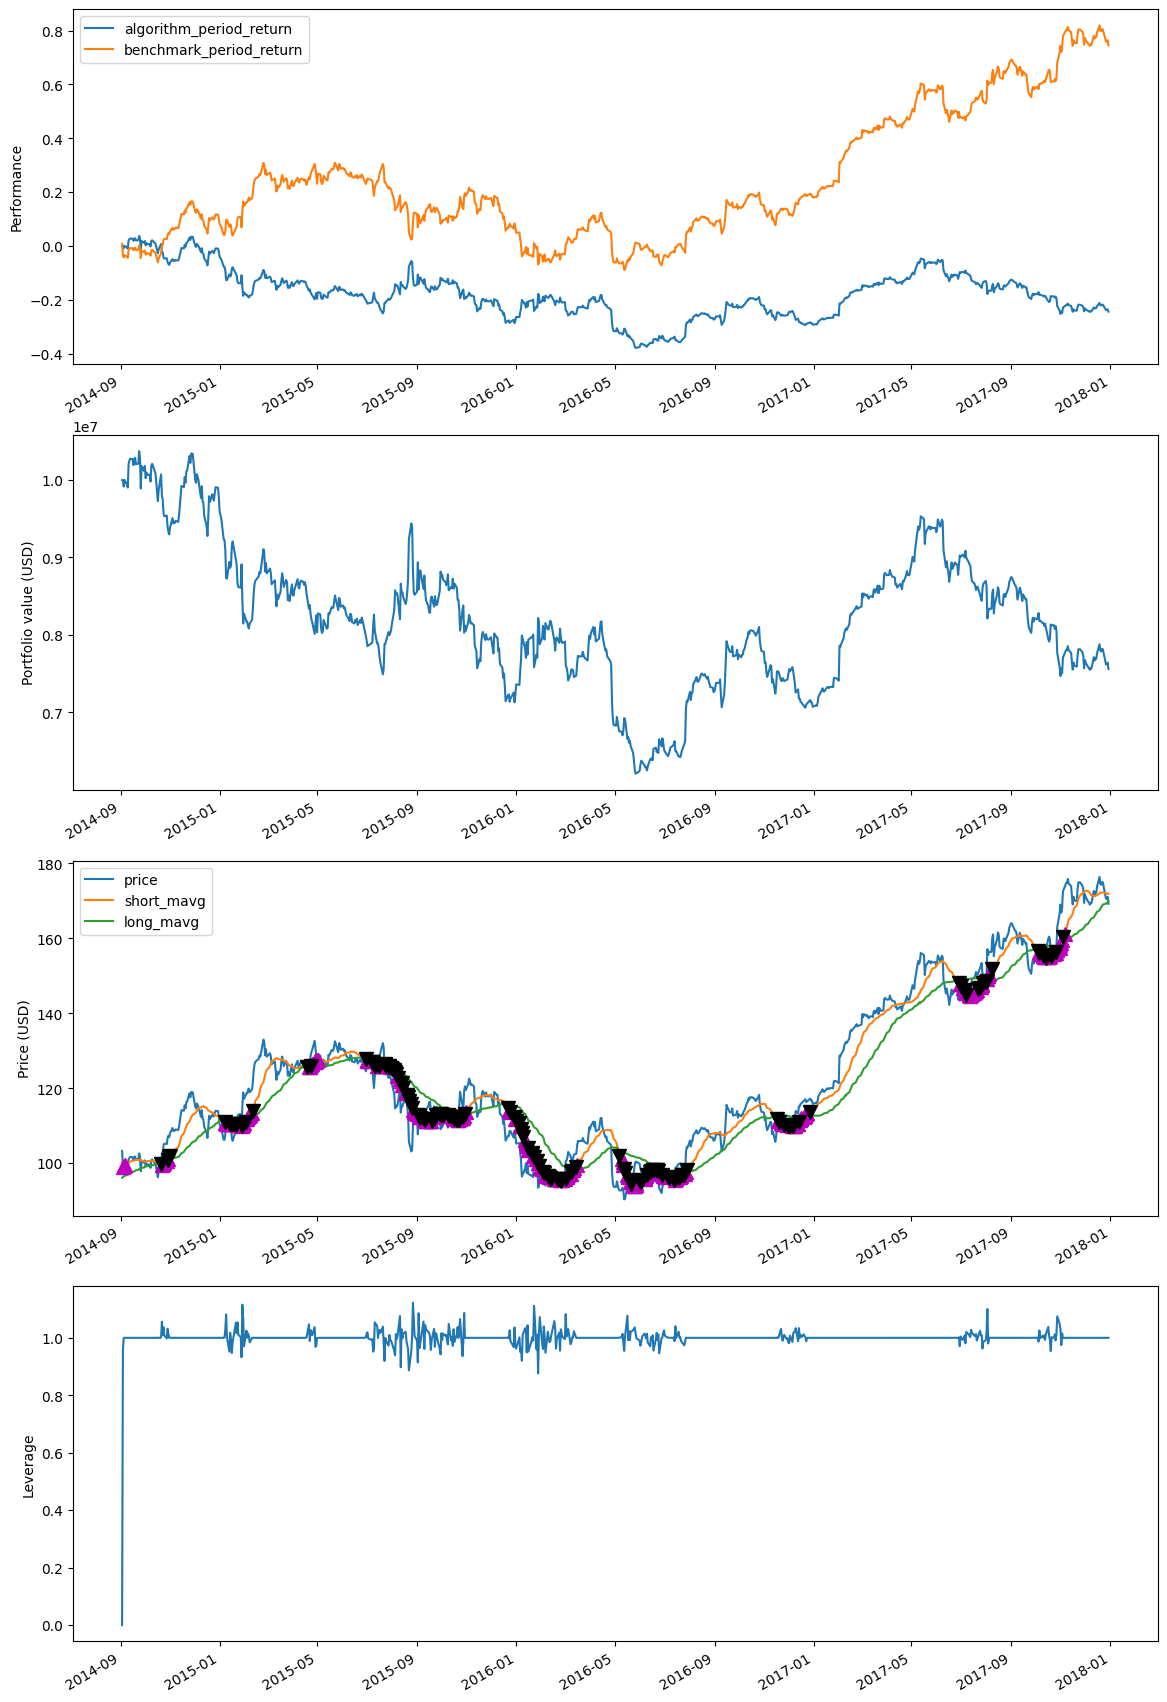

,period_open,period_close,ending_cash,portfolio_value,longs_count,shorts_count,returns,long_value,short_value,pnl,...,excess_return,treasury_period_return,trading_days,benchmark_period_return,benchmark_volatility,period_label,algorithm_period_return,algo_volatility,alpha,beta
2014-09-02 20:00:00+00:00,2014-09-02 13:31:00+00:00,2014-09-02 20:00:00+00:00,1.000000e+07,1.000000e+07,0,0,0.000000,0.00,0.0,0.00000,...,0.0,0.0,1,0.007808,NaN,2014-09,0.000000,NaN,NaN,NaN
2014-09-03 20:00:00+00:00,2014-09-03 13:31:00+00:00,2014-09-03 20:00:00+00:00,4.172276e+05,9.995114e+06,1,0,-0.000489,9577886.70,0.0,-4885.74835,...,0.0,0.0,2,-0.034727,0.561388,2014-09,-0.000489,0.005484,-0.019038,0.009769
2014-09-04 20:00:00+00:00,2014-09-04 13:31:00+00:00,2014-09-04 20:00:00+00:00,3.342579e+03,9.915523e+06,1,0,-0.007963,9912180.52,0.0,-79591.15296,...,0.0,0.0,3,-0.042730,0.405268,2014-09,-0.008448,0.070849,-0.552326,-0.025790
2014-09-05 20:00:00+00:00,2014-09-05 13:31:00+00:00,2014-09-05 20:00:00+00:00,-2.411780e+01,1.000139e+07,1,0,0.008660,10001413.35,0.0,85866.13351,...,0.0,0.0,4,-0.034438,0.377505,2014-09,0.000139,0.107911,0.245482,0.096332
2014-09-08 20:00:00+00:00,2014-09-08 13:31:00+00:00,2014-09-08 20:00:00+00:00,-2.411780e+01,9.939746e+06,1,0,-0.006163,9939769.80,0.0,-61643.55000,...,0.0,0.0,5,-0.040389,0.327352,2014-09,-0.006025,0.103348,-0.112573,0.089233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,2.903238e+01,7.817026e+06,1,0,0.000000,7816996.66,0.0,0.00000,...,0.0,0.0,836,0.805027,0.228260,2017-12,-0.218297,0.227438,-0.049168,0.009884
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,2.903238e+01,7.618709e+06,1,0,-0.025370,7618679.62,0.0,-198317.04000,...,0.0,0.0,837,0.759233,0.228575,2017-12,-0.238129,0.227721,-0.056973,0.013644
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,2.903238e+01,7.620049e+06,1,0,0.000176,7620019.60,0.0,1339.98000,...,0.0,0.0,838,0.759543,0.228439,2017-12,-0.237995,0.227585,-0.056857,0.013642
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,2.903238e+01,7.641488e+06,1,0,0.002814,7641459.28,0.0,21439.68000,...,0.0,0.0,839,0.764494,0.228306,2017-12,-0.235851,0.227455,-0.056011,0.013677


In [6]:
%%zipline --start=2014-9-1 --end=2018-1-1 --benchmark-symbol AAPL

import numpy as np
import matplotlib.pyplot as plt
from zipline.api import order_target_percent, record, symbol, get_open_orders, schedule_function, date_rules, time_rules


def initialize(context):
    context.aapl = symbol("AAPL")
    schedule_function(ma_crossover_handling, date_rules.every_day(), time_rules.market_open(hours=1))


def handle_data(context,data):
    record(leverage=context.account.leverage)


def ma_crossover_handling(context, data):

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    sma_short = data.history(context.aapl, "price", 20, "1d").mean()
    sma_long = data.history(context.aapl, "price", 50, "1d").mean()
    
    open_orders = get_open_orders()

    # Trading logic
    if sma_short > sma_long:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, 1.0)
    elif sma_short < sma_long:
        if context.aapl not in open_orders:
            order_target_percent(context.aapl, -1.0)

    # Save values for later inspection
    record(
        price=data.current(context.aapl, "price"),
        short_mavg=sma_short,
        long_mavg=sma_long,
    )


# Note: this function can be removed if running
# this algorithm on quantopian.com
def analyze(context=None, results=None):
    
    # Algorithm Metrics
    returns = results['algorithm_period_return'].iloc[-1]
    benchmark = results['benchmark_period_return'].iloc[-1]
    alpha = round(results['alpha'].iloc[-1], 2)
    beta = round(results['beta'].iloc[-1], 2)
    sharpe = results['sharpe'].iloc[-1]
    sortino = results['sortino'].iloc[-1]
    volatility = round(results['algo_volatility'].iloc[-1], 2)
    max_drawdown = results['max_drawdown'].iloc[-1]
    print(f'Returns: {returns * 100:.2f}% | Benchmark: {benchmark * 100:.2f}% | Alpha: {alpha} | Beta: {beta}')
    print(f'Sharpe: {sharpe:.2f} | Sortino: {sortino:.2f} | Volatility: {volatility}')
    print(f'Max Drawdown: {max_drawdown * 100:.2f}%')

    # Plot chart
    fig = plt.figure(figsize=[14, 24])
    
    ax1 = fig.add_subplot(411)
    results[['algorithm_period_return', 'benchmark_period_return']].plot(ax=ax1)
    ax1.set_ylabel("Performance")
    
    ax2 = fig.add_subplot(412)
    results.portfolio_value.plot(ax=ax2)
    ax2.set_ylabel("Portfolio value (USD)")

    ax3 = fig.add_subplot(413)
    ax3.set_ylabel("Price (USD)")

    # If data has been record()ed, then plot it.
    if "price" in results and "short_mavg" in results and "long_mavg" in results:
        results["price"].plot(ax=ax3)
        results[["short_mavg", "long_mavg"]].plot(ax=ax3)

        trans = results[[t != [] for t in results.transactions]]
        buys = trans[[t[0]["amount"] > 0 for t in trans.transactions]]
        sells = trans[[t[0]["amount"] < 0 for t in trans.transactions]]
        ax3.plot(
            buys.index,
            results.short_mavg.loc[buys.index],
            "^",
            markersize=10,
            color="m",
        )
        ax3.plot(
            sells.index,
            results.short_mavg.loc[sells.index],
            "v",
            markersize=10,
            color="k",
        )
        plt.legend(loc=0)
    else:
        msg = "price, short_mavg & long_mavg data not captured using record()."
        ax3.annotate(msg, xy=(0.1, 0.5))
    
    ax4 = fig.add_subplot(414)
    results.leverage.plot(ax=ax4)
    ax4.set_ylabel("Leverage")

    plt.show()